# Toronto COVID-19 Cases Project

Author: Adrienne Siu
Date: August 2020

# 1. Problem Definition

In this project, I will use machine learning to:
(1) Predict the outcomes of cases of COVID-19 in Toronto
(2) Find the variables that correlate most with the outcome

The dataset is available on Toronto Open Data and the version from July 29, 2020 was used: https://open.toronto.ca/dataset/covid-19-cases-in-toronto/

This dataset has been saved as 'COVID19 cases.csv'.

The three possible outcomes are: fatal, resolved (not fatal), and active.

In [1]:
# DELETE
#import pdb
#import contextlib
#with contextlib.redirect_stdout(None):
   #import pixiedust

In [2]:
# Import libraries
import pandas as pd
import numpy as np

# 2. Data Cleaning

In this section, I will clean the data for analysis.

In [3]:
# Path of dataset file (.csv)
covid_file_path = 'COVID19 cases.csv'

# Read the file
covid_data = pd.read_csv(covid_file_path)

In [4]:
# Display the first few rows of the dataset
covid_data.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,1,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,2,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,3,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,4,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,5,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No


In [17]:
# Function to create a table of missing values in columns
# Function written by Nikos Tavoularis on Stack Overflow: https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe/39734251#39734251
# Function comments by AS
def missing_values_table(df):
        # Count the number of missing values in each column
        mis_val = df.isnull().sum()
        # Calculate the percentage of missing values in each column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        # Put the number of missing values and % missing values in a table
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        # Rename the columns of the table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # Take out columns with no missing values
        # Reorder columns with missing values in descending order
        # Round % missing values to 1 decimal place
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # Print summary
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        # Return table of missing values
        return mis_val_table_ren_columns

In [ ]:
# DELETE
#%%pixie_debugger
#pdb.set_trace()

In [18]:
# Create table of missing values
missing_values_table(covid_data)

Your selected dataframe has 18 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Neighbourhood Name,609,4.0
FSA,563,3.7
Age Group,27,0.2


As observed, there are only 3/18 columns with missing values. For each column, the % missing values is 4% or less. Hence, the dataset is fairly complete.

I will leave the missing values as they are for the exploratory data analysis. Later, for the modelling, I will fill some of the missing values:

The age group will be filled with median imputation, i.e. the median age group.

If neither of the FSA or the neighbourhood name are known, these will remain unknown.

If one of the FSA or the neighbourhood name is known, the other will be inferred.

In [7]:
# Look for categorical variables
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15338 entries, 0 to 15337
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   _id                     15338 non-null  int64 
 1   Assigned_ID             15338 non-null  int64 
 2   Outbreak Associated     15338 non-null  object
 3   Age Group               15311 non-null  object
 4   Neighbourhood Name      14729 non-null  object
 5   FSA                     14775 non-null  object
 6   Source of Infection     15338 non-null  object
 7   Classification          15338 non-null  object
 8   Episode Date            15338 non-null  object
 9   Reported Date           15338 non-null  object
 10  Client Gender           15338 non-null  object
 11  Outcome                 15338 non-null  object
 12  Currently Hospitalized  15338 non-null  object
 13  Currently in ICU        15338 non-null  object
 14  Currently Intubated     15338 non-null  object
 15  Ev

Apart from the patient ID, the columns are all categorical variables. I will deal with encoding for categorical variables in the modelling section.

# 3. Exploratory Data Analysis (EDA)

In this section, I will explore the data, including correlations between variables and outcomes.

In [29]:
# Number of distinct values in Neighbourhood Name, FSA, and Age Group columns
covid_data['Neighbourhood Name'].value_counts()

Glenfield-Jane Heights               510
West Humber-Clairville               495
Mount Olive-Silverstone-Jamestown    492
Downsview-Roding-CFB                 454
York University Heights              430
                                    ... 
The Beaches                           17
Lambton Baby Point                    16
Blake-Jones                           15
Yonge-Eglinton                        15
Danforth                              13
Name: Neighbourhood Name, Length: 140, dtype: int64

In [30]:
covid_data['FSA'].value_counts()

M9V    884
M3N    687
M6M    495
M1E    451
M9W    434
      ... 
M4T     13
M5C     13
M4R     12
M5H     11
M2P     10
Name: FSA, Length: 96, dtype: int64

In [31]:
covid_data['Age Group'].value_counts()

50 to 59 Years    2424
20 to 29 Years    2230
30 to 39 Years    2182
40 to 49 Years    2156
60 to 69 Years    1646
80 to 89 Years    1538
90 and older      1107
70 to 79 Years    1064
19 and younger     964
Name: Age Group, dtype: int64

In [57]:
# Get the count of each unique entry
age_vc = covid_data['Age Group'].value_counts()
# Get the unique entries and put them in a list
age = age_vc.index.tolist()

Text(0.5, 1.0, 'Number of COVID-19 Cases By Age Group')

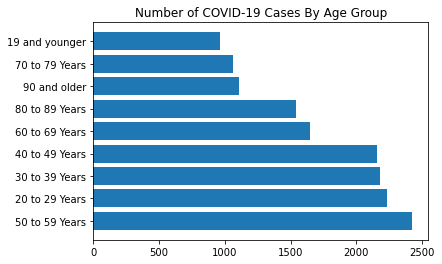

In [67]:
# Bar graphs of each variable
import matplotlib.pyplot as plt

plt.barh(age, age_vc)
plt.title('Number of COVID-19 Cases By Age Group')